In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

# model functionality and validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# regressor models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [114]:
# data pipeline

# read in file
raw_data = pd.read_csv("AmesHousing.csv", "~")

# see what has been loaded
raw_data.keys()

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "Lot Frontage", "Lot Area", 
                 "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", 
                 "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", 
                 "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", 
                 "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", 
                    "Bedroom AbvGr", "Garage Cars", "Yr Sold", "Overall Qual", "Lot Area", "Lot Frontage"]]


##############################################################################
# use the oneHot encoder to create dummy columns for overall quality #########
##############################################################################
encoder = OneHotEncoder()
temp = simple_data["Overall Qual"]
overall_qual_dummies = encoder.fit_transform(temp.values.reshape(-1, 1))
overall_qual_dummies = overall_qual_dummies.toarray()
print "overall_qual_dummies shape:", overall_qual_dummies.shape

oq_dummies = pd.DataFrame(overall_qual_dummies, columns=["oq_1", "oq_2", "oq_3", "oq_4", "oq_5", "oq_6", 
                                                         "oq_7", "oq_8", "oq_9", "oq_10"])
# print oq_dummies.head()

simple_data = pd.concat((simple_data, oq_dummies), axis=1)
simple_data.pop("Overall Qual")


# Fuzzing Quality seemed to hurt accuracy, perhaps because there wasn't a super dominant feature
# print simple_data.keys()
# simple_data.loc["Overall Qual"] = simple_data[simple_data["Overall Qual"] + np.random.uniform(-0.001, 0.001, size=len(simple_data))]
# simple_data.loc[:, "Overall Qual"] += np.random.normal(-0.001, 0.001, size=1)


##############################################################################
# Figure out Square footage information                              #########
##############################################################################
# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.pop(0)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

simple_data["Lot Frontage"].fillna(simple_data["Lot Frontage"].mean(), inplace=True)

##############################################################################
# Create "lot_ratio" which is "Lot Area" / "Lot Frontage"            #########
##############################################################################
simple_data.loc[:, "lot_length"] = simple_data.loc[:,"Lot Area"] / (simple_data.loc[:, "Lot Frontage"] * 1.0)

simple_data.loc[:, "lot_ratio"] = simple_data.loc[:,"Lot Frontage"] / (simple_data.loc[:, "lot_length"] * 1.0)
simple_data.pop("lot_length")

##############################################################################
# Bathroom feature manipulation                                      #########
##############################################################################
# combine bathroom stats
simple_data.loc[:, "total_baths"] = simple_data.loc[:, "Full Bath"] + simple_data.loc[:, "Half Bath"]

simple_data.loc[:, "bed_to_bath"] = simple_data.loc[:, "Bedroom AbvGr"] / (simple_data.loc[:, "total_baths"] * 1.0)

############################################################################## 
# Pop out pricing labels                                             #########
##############################################################################
Y = simple_data.loc[:,"SalePrice"]

##############################################################################
# Print out basic info for constructed dataframe                     #########
##############################################################################
simple_data.pop("SalePrice")
print simple_data.describe()

print
print simple_data.info()

##############################################################################
# Track Feature Engineering Evolution                                #########
##############################################################################

# try to fuzz "Overall Qual" so that it can't totally drill in on any particular value
# Starting ensemble with "simple_data" 
# Mean RMSE of 10 Runs:54667.0
#
# Add "Overall Qual" feature
# Mean RMSE of 10 Runs:46235.5
#
# Fuzzed "Overall Qual" Feature
# Mean RMSE of 10 Runs:46102.1
#
# Dummified "Overall Qual" feature
# Mean RMSE of 10 Runs:46572.3
# really helped RandomForests and LinearRegression though
#
# Tuned Gradient Boosting Hyper Parameters with quality dummies disabled
# Mean RMSE of 10 Runs:37670.7
#
# Enabled Dummified overall quality
# Mean RMSE of 10 Runs:38282.8
#
# Modified splitting to keep 20% of original data for use as validation set to prevent
# overall overfitting because the model tuning is being run so many times
# Mean RMSE of 10 Runs:38118.5
#
# Include "Lot Area" feature
# Mean RMSE of 10 Runs:36766.1
#
# Include "Lot Frontage" feature
# Mean RMSE of 10 Runs:34989.0
#
# Create "lot_length" feature "Lot Area" / "Lot Frontage"
# Mean RMSE of 10 Runs:37455.6
#
# Create "lot_ratio" which is "Lot Frontage" / "lot_length"
# Mean RMSE of 10 Runs:35728.2
#
# Create "total_baths"
# Mean RMSE of 10 Runs:36547.2
#
# Tuned DecisionTree max_depth hyper parameter to 7
# Mean RMSE of 10 Runs:34161.9

overall_qual_dummies shape: (2930, 10)
        Year Built    Full Bath    Half Bath  Bedroom AbvGr  Garage Cars  \
count  2930.000000  2930.000000  2930.000000    2930.000000  2930.000000   
mean   1971.356314     1.566553     0.379522       2.854266     1.766212   
std      30.245361     0.552941     0.502629       0.827731     0.761137   
min    1872.000000     0.000000     0.000000       0.000000     0.000000   
25%    1954.000000     1.000000     0.000000       2.000000     1.000000   
50%    1973.000000     2.000000     0.000000       3.000000     2.000000   
75%    2001.000000     2.000000     1.000000       3.000000     2.000000   
max    2010.000000     4.000000     2.000000       8.000000     5.000000   

           Yr Sold       Lot Area  Lot Frontage         oq_1         oq_2  \
count  2930.000000    2930.000000   2930.000000  2930.000000  2930.000000   
mean   2007.790444   10147.921843     69.224590     0.001365     0.004437   
std       1.316613    7880.017759     21.3215

## Function Definitions:

In [107]:
def make_data_splits(X, Y):
    '''
    Take data in and split it into 3 sets for a 2 stage stacked ensemble
    return 3 X_set splits and 3 y_set splits like:
    X_train1, X_train2, X_test, y_train1, y_train2, y_test
    '''
    # split the data for train and test
    X_train, X_test, y_train, y_test = train_test_split(X.values, Y, test_size=0.20)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

#     print "y_train", y_train.shape
#     print "X_train", X_train.shape
#     print "y_test", y_test.shape
#     print "X_test", X_test.shape

    # subdivide again for 2 stage ensemble
    X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

    y_train1 = y_train1.reshape(-1, 1)
    y_train2 = y_train2.reshape(-1, 1)
    
    return X_train1, X_train2, X_test, y_train1, y_train2, y_test

def run_multi_stack(X, y):
    '''
    Simply take the average prediction of several models and use that for a prediction
    
    Returns the RMSE resulting from that
    '''
    
    # tuned stage 1 gradient boosting with n_estimators 10,000 learning rate 0.001
    # Mean RMSE of 10 Runs:38670.5

    # tuned stage 1 gradient boosting with n_estimators 1,000 learning rate 0.01
    # Mean RMSE of 10 Runs:38626.6

    # tuned stage 2 gradient boosting with n_estimators 1,000 learning rate 0.01
    # Mean RMSE of 10 Runs:37670.7
    
    # tuned DecisionTreeRegressor with max depth from 1 to 100 and ~7 was the minimum
    
    # prevent overfitting on eval type data esp since we're doing a junky for loop for multiple
    # fold testing
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=42, test_size=0.2)
    
    # split the data for train and test
    X_train1, X_train2, X_test, y_train1, y_train2, y_test = make_data_splits(X_train, y_train)
    
    m1 = SVR(C=2.0)
    m2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    m4 = LinearRegression(fit_intercept=True)
    m5 = DecisionTreeRegressor(max_depth=7)
    
    models = [m2, m3, m4, m5]
    
    preds = np.zeros((len(y_train2), len(models)))
    for idx, model in enumerate(models):
        # print "Fitting {}...".format(model.__class__.__name__)
        model.fit(X_train1, y_train1.ravel())
        
        # print "Predicting {}...".format(model.__class__.__name__)
        results = model.predict(X_train2).ravel()
        
        preds[:,idx] = results
        

    # figure out RMSE of the average of the preds
    rmses = []
    for x in range(len(models)):
        rmse = np.sqrt(mean_squared_error(preds[:,x], y_train2.ravel()))
        rmses.append(rmse)
    
#     print "\n\n"
    print "First stage RMSEs:"
    print "{:<20} {:<20} {:<20} {:<20}".format("Random Forest", "Gradient Boosting", "Linear Regression", "Decision Tree")
    print "{:<20} {:<20} {:<20} {:<20}".format(rmses[0], rmses[1], rmses[2], rmses[3])
#     print "\n\n"
    
    # second stage model that takes predictions from models trained on first whack of data
    blender = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    
    # fit blender
    blender.fit(preds, y_train2)
    
    # now take in the whole pipeline on the test set
    
    # first get predictions on test set from the stage 1 models
    final_s1_preds = np.zeros((len(y_test), len(models)))
    
    for idx, model in enumerate(models):
        #print "Predicting Test data with {}...".format(model.__class__.__name__)
        results = model.predict(X_test).ravel()
        
        final_s1_preds[:,idx] = results
    
    final_preds = blender.predict(final_s1_preds)
    
    rmse = np.sqrt(mean_squared_error(final_preds, y_test))
    
    print "\nFinal RMSE:{:6.1f}\n".format(rmse)
    
    return rmse

## Run model 10 times to get mean RMSE

In [108]:
num_runs = 10

outcomes = np.zeros((num_runs,1))

for x in range(num_runs):
    outcomes[x] = run_multi_stack(simple_data, Y)
    
print "\nMean RMSE of 10 Runs:{:6.1f}".format(outcomes.mean())

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Decision Tree       
37235.0288876        36437.8808957        38037.7163133        46930.1064278       

Final RMSE:31341.2

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Decision Tree       
39376.8732412        36851.4827096        39113.3727638        50969.3030122       

Final RMSE:36850.1

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Decision Tree       
36356.5965695        36436.46109          36506.8391211        43499.0583145       

Final RMSE:35979.4

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Decision Tree       
36282.9117412        35005.6673322        39311.8519379        43841.6209413       

Final RMSE:29864.3

First stage RMSEs:
Random Forest        Gradient Boosting    Linear Regression    Decision Tree       
35678.7189354        34770.8896146        38392.0838927        46

In [105]:
X_core, X_eval, y_core, y_eval = train_test_split(simple_data.values, Y, random_state=42, test_size=0.2)

errors = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors.append(np.array(RMSEs).mean())

errors1 = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors1.append(np.array(RMSEs).mean())
    

errors2 = []

for ida in range(1, 21):
    RMSEs = []

    for idx in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.3)
        
        #print X_train.shape, y_train.shape, X_test.shape, y_test.shape

        model = DecisionTreeRegressor(max_depth=ida)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        RMSE = np.sqrt(mean_squared_error(preds, y_test))

        RMSEs.append(RMSE)

    print RMSEs
    print np.array(RMSEs).mean()
    errors2.append(np.array(RMSEs).mean())

[62237.514058380184, 63444.528641064404, 59680.887695378195, 60630.746665765262, 60952.066046780674]
61389.1486215
[54224.137452528455, 51352.207204596729, 58860.248158449584, 57935.851360577166, 55710.479064933832]
55616.5846482
[49403.02685010108, 53882.58390618991, 49747.816763966381, 50134.775031712925, 48585.476843099859]
50350.735879
[39395.437173524777, 46784.130601579942, 45404.212825164766, 46574.217596199051, 47964.499016364469]
45224.4994426
[44604.779202284946, 46423.793225199544, 41943.356734913046, 42986.629833023369, 43868.894586590155]
43965.4907164
[43200.409110330133, 40766.569112375422, 40560.815487115186, 43057.035996796461, 40677.615313159949]
41652.489004
[43873.134297490469, 43451.355701853332, 44897.236099790338, 45117.581786253453, 41424.133581110953]
43752.6882933
[44226.047055895855, 42129.911815107334, 42486.498396325216, 44885.052234403331, 39071.252631415889]
42559.7524266
[39737.68301494664, 44462.398531116363, 42824.741352162746, 41836.618577000976, 4315

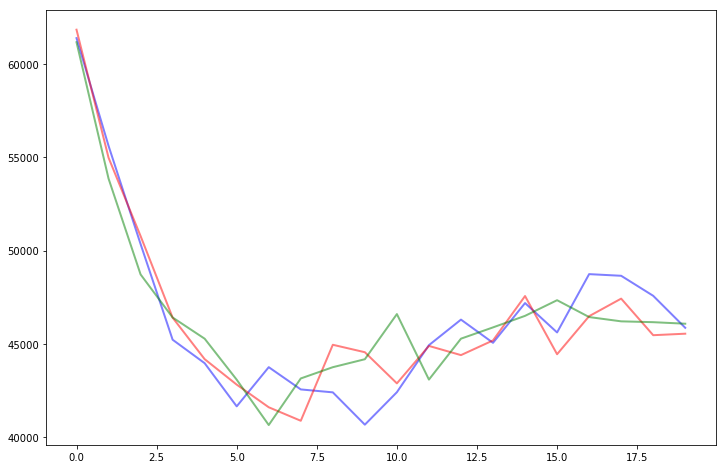

In [106]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(errors, lw=2, color="blue", alpha=0.5)
ax.plot(errors1, lw=2, color="red", alpha=0.5)
ax.plot(errors2, lw=2, color="green", alpha=0.5)